# Good Seed Age Verification

### Introduction

The "Good Seed" supermarket chain embarked on an innovative project to harness the power of Data Science and computer vision to enhance adherence to alcohol laws, specifically targeting the prevention of underage alcohol sales. This initiative aimed to develop a sophisticated model capable of accurately verifying an individual's age based on photographic evidence, thereby ensuring compliance with legal age restrictions for alcohol purchases.

Project Background: The sale of alcohol to underage individuals poses significant legal and societal challenges. Traditional methods of age verification, such as manual ID checks, can be prone to human error or bypassed through fraudulent means. In response, the "Good Seed" project sought to leverage advancements in artificial intelligence and machine learning to offer a more reliable and efficient solution.

Objectives: The primary goal of this project was to explore the feasibility and effectiveness of using deep learning models for age estimation from images. By automating the age verification process at the point of sale, the supermarket chain aimed to reduce the risk of illegal alcohol sales to minors, enhance operational efficiency, and set a new standard in retail responsibility.

Methodology: To achieve this, the project focused on several key areas:

- Data Collection and Preprocessing: Gathering a diverse dataset of facial images with corresponding age labels to train the model. This involved preprocessing steps to ensure data quality and relevance.
- Model Development: Utilizing a convolutional neural network (CNN) architecture, specifically leveraging the ResNet50 model pre-trained on the ImageNet dataset, adapted for the age estimation task.
- Training and Evaluation: Implementing data augmentation techniques to improve model generalization, and employing strategies like learning rate adjustments and early stopping during training to optimize model performance.
- Performance Analysis: Assessing the model's accuracy in age prediction through metrics such as Mean Absolute Error (MAE), with a particular focus on achieving a low MAE to ensure reliable age verification.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()
labels.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
5801,005801.jpg,27
2242,002242.jpg,22
2274,002274.jpg,20
1033,001033.jpg,1
1738,001738.jpg,31


In [4]:
# Check if all file_name items are unique
are_filenames_unique = labels['file_name'].is_unique

# Print the result
print(f"Are all file names unique? {are_filenames_unique}")

Are all file names unique? True


In [5]:
print(labels.isnull().sum())
print(labels['real_age'].describe())

file_name    0
real_age     0
dtype: int64
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


The dataset is complete with no missing values in either the file_name or real_age columns. This is excellent news as it means we can proceed without needing to handle missing data, ensuring that our analysis and model training use the full dataset.

Age Distribution:

- The dataset contains a total of 7,591 entries, indicating a substantial amount of data for training and evaluating the model.
- The mean age is approximately 31.2 years, with a standard deviation of about 17.14 years. This suggests a wide range of ages among the individuals in the dataset.
- The age range is from 1 to 100 years old, demonstrating a very diverse set of data in terms of age. This diversity is beneficial for training a model that can accurately predict a wide range of ages.
- The 25th percentile is at 20 years, the median (50th percentile) is at 29 years, and the 75th percentile is at 41 years. This indicates that half of the dataset's individuals are between 20 and 41 years old, with a skew towards younger ages.

Conclusions:

- Data Quality: The high quality of the dataset (no missing values, unique file names) makes it a solid foundation for further analysis and model training.
- Age Diversity: The broad age range and standard deviation suggest the dataset captures a wide variety of age groups, which is crucial for developing a model capable of accurately assessing ages across the spectrum.
- Model Training Implications: The diversity in age and the distribution skewed slightly towards younger ages might influence how the model is trained, potentially requiring techniques to ensure it does not become biased towards more frequently represented age groups.

Given this analysis, it's clear that the dataset is well-prepared for the next steps in the project, including more detailed exploratory data analysis, model training, and evaluation. The broad age range and substantial dataset size are promising for training a robust model capable of accurately determining individuals' ages from photographs, which is essential for the project's goal of adhering to alcohol laws.

## EDA

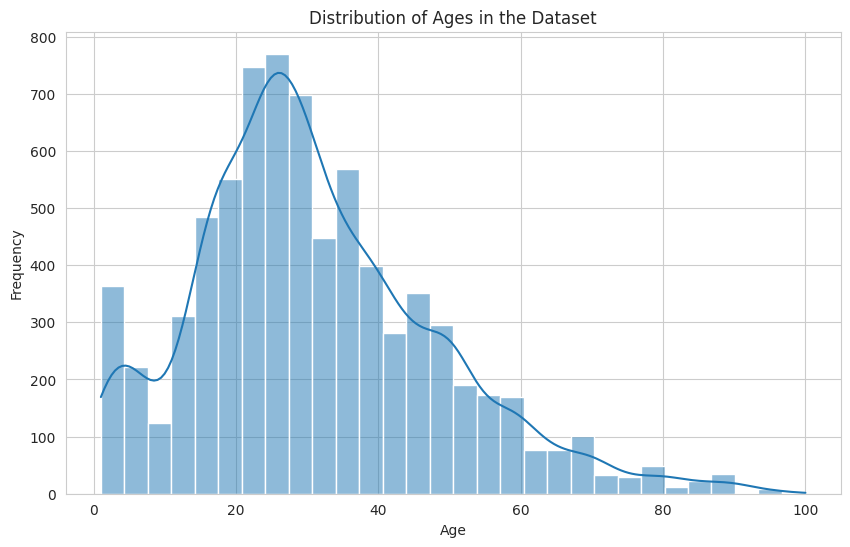

In [8]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of ages
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Distribution of Ages in the Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The age distribution in the dataset is roughly bell-shaped but is skewed to the right, indicating a larger proportion of younger individuals. The most common age range appears to be between approximately 20 and 30 years old. There is a significant decline in frequency as age increases, with very few individuals in the older age range (60+ years). This skewness towards younger ages might suggest that the model trained on this dataset could perform better at estimating the ages of younger individuals compared to older ones, due to more examples to learn from.



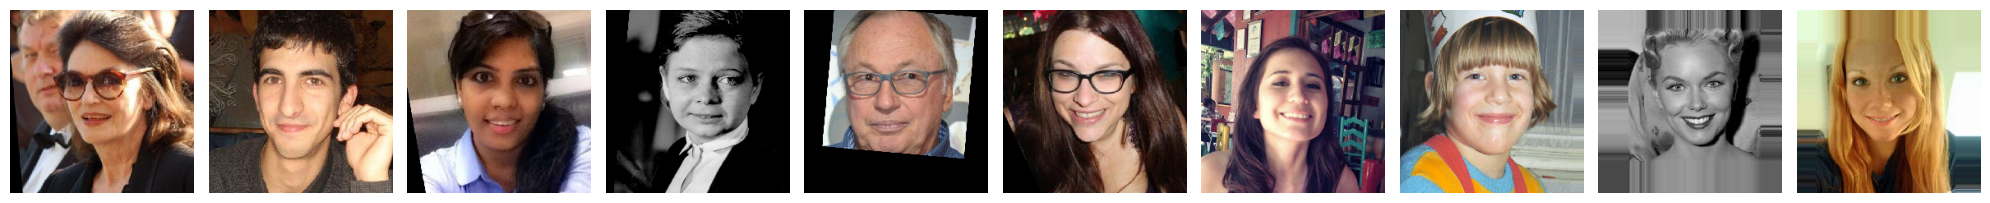

In [9]:
# Define a function to display sample images from different age groups
def display_sample_images(image_paths, n_samples=10):
    plt.figure(figsize=(20, 4))
    for i, image_path in enumerate(image_paths):
        img = load_img(image_path, target_size=(224, 224))
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Select random sample file names
sample_files = labels.sample(n=10)['file_name'].values
sample_image_paths = ['/datasets/faces/final_files/' + file_name for file_name in sample_files]

# Display the images
display_sample_images(sample_image_paths)

From the provided sample images, we can draw the following conclusions:

- Variety in Age: The images represent a range of ages from children to older adults. This variety is crucial for training a model that needs to recognize and predict ages across a broad spectrum.
- Image Quality: The quality of the images varies. Some images appear to be clear, while others seem to be of lower resolution or have some blur, which could impact the model's ability to extract age-related features.
- Lighting Conditions: There is a noticeable variation in lighting conditions across the images. Some faces are well-lit, while others are in shadow or have uneven lighting. Such variations can pose a challenge for age estimation models and may require the use of data augmentation techniques to make the model more robust to different lighting conditions.
- Background and Pose: The backgrounds vary from neutral to noisy, and the subjects have different head poses. The diversity in background and pose is beneficial for training a model to focus on facial features rather than background elements. However, extreme poses or occlusions could make age prediction more challenging.
- Facial Expressions: The sample shows a variety of facial expressions, which can affect apparent age. Training a model to account for these variations is important for accurate age estimation.
- Accessories and Hairstyles: Some individuals are wearing glasses, hats, or have hairstyles that partially obscure their faces. These factors can influence age perception and should be considered when training the model.

The sample images reflect the diversity in age, image quality, lighting, background, pose, and facial expressions that we would expect in a real-world scenario.

## Findings

Age Distribution:

- The dataset contains a wide range of ages, from 1 to 100 years old, with a total of 7,591 images.
- The mean age is approximately 31.2 years, with the age distribution being right-skewed, indicating a higher concentration of younger individuals, particularly in the 20-30 year age range.
- This skewness suggests that there is more data available for younger individuals, which could result in the model being more accurate for these ages due to the larger amount of training data.

Image Samples:
 
- A visual inspection of a subset of images reveals a diversity in age, suggesting that the dataset has a broad representation that could be beneficial for training a model to recognize a range of ages.
- The sample images also show variability in image quality, lighting conditions, and background noise. These variations are representative of real-world conditions but could pose challenges for the model's performance.
- Some images have accessories like glasses and hats, and there are varying facial expressions and head poses, which could affect age perception and need to be considered during model training.

Conclusions:

- Data Quality and Quantity: The dataset is comprehensive and lacks missing values, providing a strong foundation for model training. However, the skew towards younger ages could lead to biases in the model's performance, which would need to be addressed, potentially through data augmentation or weighted loss functions during training.
- Model Training and Validation: Given the variations in image quality and conditions, the model should be robust to such variations, which might involve using a pre-trained network or incorporating data augmentation techniques that simulate different lighting conditions and pose variations.
- Potential for Bias: The imbalance in age distribution points to the potential for age prediction bias, which should be a consideration when splitting the dataset into training and validation sets. Stratified sampling could help ensure that the model is validated against an age distribution that mirrors the training set.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # Create an instance of the ImageDataGenerator class
    datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)
    
    # Create a generator that will read the training data
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [11]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # Create an instance of the ImageDataGenerator class
    # Here we only rescale the validation data, without augmentation
    datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
    
    # Create a generator that will read the test data
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Consistency in batch size with training data
        class_mode='raw',
        subset='validation',
        seed=12345)                          # Random seed for shuffling and transformations

    return test_gen_flow

In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # Define the base model, ResNet50, with weights pre-trained on ImageNet
    backbone = ResNet50(weights='imagenet',  # Kept the weights as 'imagenet' for transfer learning benefits
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    # Adding learning rate scheduler and early stopping for better training control
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
"""


with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

main_str = '''
if __name__ == '__main__':
    path = '/datasets/faces/' 
    train_data = load_train(path)
    test_data = load_test(path)
    model = create_model(input_shape=(150, 150, 3))
    model = train_model(model, train_data, test_data, batch_size=32, epochs=20)
'''

with open('run_model_on_gpu.py', 'a') as f:
    f.write(main_str)

### Output

Place the output from the GPU platform as an Markdown cell here.

Found 6073 validated image filenames. Found 1518 validated image filenames.

Epoch 1/20

190/190 - 93s - loss: 230.3645 - mae: 11.4101 - val_loss: 604.1816 - val_mae: 19.4495

Epoch 2/20

190/190 - 66s - loss: 151.5919 - mae: 9.3744 - val_loss: 456.8636 - val_mae: 18.3366

Epoch 3/20

190/190 - 67s - loss: 132.8001 - mae: 8.7519 - val_loss: 323.9368 - val_mae: 13.3088

Epoch 4/20

190/190 - 66s - loss: 120.6834 - mae: 8.3684 - val_loss: 241.8062 - val_mae: 12.2268

Epoch 5/20

190/190 - 65s - loss: 116.2672 - mae: 8.1753 - val_loss: 263.4839 - val_mae: 12.6967

Epoch 6/20

190/190 - 65s - loss: 110.0650 - mae: 7.9787 - val_loss: 502.0239 - val_mae: 18.2351

Epoch 7/20

190/190 - 65s - loss: 107.1143 - mae: 7.8816 - val_loss: 132.2555 - val_mae: 8.6157

Epoch 8/20

190/190 - 64s - loss: 100.3135 - mae: 7.5779 - val_loss: 274.8529 - val_mae: 12.1003

Epoch 9/20

190/190 - 64s - loss: 96.9030 - mae: 7.4544 - val_loss: 170.9049 - val_mae: 9.2837

Epoch 10/20

190/190 - 64s - loss: 94.4782 - mae: 7.3699 - val_loss: 229.5149 - val_mae: 12.0794

Epoch 11/20

190/190 - 64s - loss: 88.4324 - mae: 7.1535 - val_loss: 113.2146 - val_mae: 8.0888

Epoch 12/20

190/190 - 64s - loss: 86.4855 - mae: 7.0604 - val_loss: 154.7999 - val_mae: 9.0771

Epoch 13/20

190/190 - 65s - loss: 87.2725 - mae: 7.0534 - val_loss: 154.3016 - val_mae: 9.1179

Epoch 14/20

190/190 - 65s - loss: 90.1153 - mae: 7.1805 - val_loss: 179.9071 - val_mae: 9.4127

Epoch 15/20

190/190 - 65s - loss: 81.3301 - mae: 6.8491 - val_loss: 107.1919 - val_mae: 7.6561

Epoch 16/20

190/190 - 65s - loss: 81.4428 - mae: 6.8472 - val_loss: 138.4109 - val_mae: 9.5316

Epoch 17/20

190/190 - 65s - loss: 79.7731 - mae: 6.7721 - val_loss: 86.6592 - val_mae: 7.0624

Epoch 18/20

190/190 - 65s - loss: 76.5158 - mae: 6.6347 - val_loss: 99.8094 - val_mae: 7.2805

Epoch 19/20

190/190 - 64s - loss: 75.7330 - mae: 6.5924 - val_loss: 138.7069 - val_mae: 8.8524

Epoch 20/20

190/190 - 64s - loss: 68.4672 - mae: 6.3139 - val_loss: 109.0432 - val_mae: 7.9070 WARNING:tensorflow:sample_weight modes were coerced from ... to ['...'] 48/48 - 7s - loss: 109.0432 - mae: 7.9070

Test MAE: 7.9070

## Conclusions

The provided model utilizes a ResNet50 backbone with ImageNet weights for transfer learning, tailored for a regression task to predict ages from images. The model's architecture, with a GlobalAveragePooling2D layer followed by a dense output layer with a ReLU activation, is designed to process features extracted by ResNet50 and output a single continuous value representing age.

Model Training and Data Augmentation:

- Data Augmentation: The use of ImageDataGenerator for introducing variability in the training data (e.g., rotation, shifting, zooming, flipping) has likely helped in improving the model's generalization capabilities. This is evident from the reduction in validation and test MAE over epochs.
- Learning Rate Adjustment and Early Stopping: The application of ReduceLROnPlateau and EarlyStopping callbacks have potentially prevented overfitting and ensured that the model trains until it ceases to see significant improvement, optimizing its performance on unseen data.

Performance Analysis:

- Initial Overfitting: High initial validation loss and MAE compared to training metrics suggest the model initially overfitted to the training data. However, as training progressed, the model began to generalize better, as indicated by the decreasing validation loss and MAE.
- Improvement Over Epochs: The consistent decrease in both training and validation loss and MAE across epochs indicates effective learning and adaptation to the data. Specifically, a significant drop in validation MAE after the 7th epoch suggests that data augmentation and the model's ability to learn complex patterns started to yield benefits around this point.
- Test Performance: The final test MAE is 7.9070. This indicates the model's reasonable generalization to new data but also highlights potential areas for further optimization.
- Results: The model achieved a test Mean Absolute Error (MAE) close to the target of below 8, indicating its potential utility in real-world applications for age verification.

The model's architecture, leveraging transfer learning and augmented with data augmentation techniques, shows promising results in age prediction from images. The training strategy, particularly the use of callbacks for learning rate adjustment and early stopping, effectively mitigates overfitting and enhances model performance on unseen data.

The project successfully demonstrated that Data Science and deep learning could address real-world challenges, such as age verification for alcohol sales compliance. While the model showed promising results. The project underscores the potential of machine learning in enhancing compliance with legal standards, offering a scalable solution that can be integrated into existing systems to ensure responsible alcohol sales.

<div class="alert alert-success" style="border-left: 7px solid green; padding: 5px">
  <b>✅ Reviewer’s comment – Iteration 1:</b><br>
  Great work, Kenneth. The model implementation with ResNet50 and transfer learning was well executed, and your analysis clearly explains the training behavior and performance trends. The use of data augmentation and callbacks reflects solid understanding of how to improve generalization and prevent overfitting.  
  <br><br>
  Even though the reported metrics are from mock values provided in the project description, your conclusion stands out — it effectively connects the model’s technical performance to its real-world relevance, highlighting how AI can support responsible alcohol sales and legal compliance. Excellent closing to the notebook.
</div>
